#**Project : Speech Emotion Recognition**

##**Problem Statement:**

In the realm of Speech Emotion Recognition, the CREMA-D dataset stands out as a comprehensive and diverse collection comprising 7,442 original audio clips sourced from 91 actors. This dataset offers a unique advantage due to the extensive variability it presents, featuring contributions from 48 male and 43 female actors spanning a wide age range of 20 to 74, and representing a diverse array of races and ethnicities, including African American, Asian, Caucasian, Hispanic, and Unspecified. Each actor vocalizes a selection of 12 sentences, expressing a spectrum of six distinct emotions: Anger, Disgust, Fear, Happy, Neutral, and Sad. Adding to the complexity, the dataset introduces four emotion levels, categorized as Low, Medium, High, and Unspecified. The significance of CREMA-D lies in its richness of speakers, ensuring that any model trained on this dataset is poised to generalize effectively across diverse datasets, mitigating the risk of overfitting that often arises in more homogenous speaker datasets. In light of these attributes, the problem at hand involves the development of an emotion classifier capable of accurately discerning and categorizing emotions from audio data, leveraging the wealth of information encapsulated within the CREMA-D dataset.

##**Import Libraries**

In [27]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Load Dataset**

In [3]:
dataset_path = '/content/drive/MyDrive/Interview_question_solved/Deep learning learning/Models/Dataset/CREMA-D'

In [4]:
def extract_labels_from_filename(filename):
    parts = filename.split('_')
    if len(parts) >= 3:
        emotion = parts[2]
        return emotion
    else:
        return 'Unknown'

def load_dataset(dataset_path):
    dataset = []
    for actor_folder in os.listdir(dataset_path):
        actor_folder_path = os.path.join(dataset_path, actor_folder)
        if os.path.isdir(actor_folder_path):
            for audio_file in os.listdir(actor_folder_path):
                audio_file_path = os.path.join(actor_folder_path, audio_file)
                # Check if it's a file before loading
                if os.path.isfile(audio_file_path):
                    try:
                        # Load audio file using librosa
                        audio_data, sample_rate = librosa.load(audio_file_path, sr=None)

                        # Extract emotion from filename
                        emotion = extract_labels_from_filename(audio_file)

                        dataset.append({
                            'actor': actor_folder,
                            'audio_data': audio_data,
                            'sample_rate': sample_rate,
                            'emotion': emotion
                        })
                    except Exception as e:
                        print(f"Error loading {audio_file_path}: {e}")
    return dataset

In [5]:
speech_dataset = load_dataset(dataset_path)

In [6]:
df_speech = pd.DataFrame(speech_dataset)
df_speech.head()

,actor,audio_data,sample_rate,emotion
0,AudioWAV,"[-0.0014953613, -0.0018005371, -0.001739502, -...",16000,SAD
1,AudioWAV,"[-0.004180908, -0.004425049, -0.0053710938, -0...",16000,ANG
2,AudioWAV,"[0.0021362305, 0.00390625, 0.0036621094, 0.003...",16000,ANG
3,AudioWAV,"[-0.0055236816, -0.0054016113, -0.006591797, -...",16000,ANG
4,AudioWAV,"[0.0015258789, 0.00076293945, 0.0005187988, 0....",16000,NEU


In [7]:
df_speech['emotion'].value_counts()

SAD    1271
ANG    1271
DIS    1271
HAP    1271
FEA    1271
NEU    1087
Name: emotion, dtype: int64

In [11]:
df_speech.shape

(7442, 4)

In [34]:
df_speech.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7442 entries, 0 to 7441
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   actor        7442 non-null   object
 1   audio_data   7442 non-null   object
 2   sample_rate  7442 non-null   int64 
 3   emotion      7442 non-null   object
dtypes: int64(1), object(3)
memory usage: 232.7+ KB


##**Mapping Dictionary**

In [8]:
# Define a mapping dictionary
emotion_mapping = {'FEA': 'Fear', 'HAP': 'Happy', 'SAD': 'Sad', 'ANG': 'Angry', 'DIS': 'Disgust', 'NEU': 'Neutral'}

# Use the map function to replace values
df_speech['emotion'] = df_speech['emotion'].map(emotion_mapping)

In [9]:
df_speech['emotion'].value_counts()

Sad        1271
Angry      1271
Disgust    1271
Happy      1271
Fear       1271
Neutral    1087
Name: emotion, dtype: int64

##**EDA**

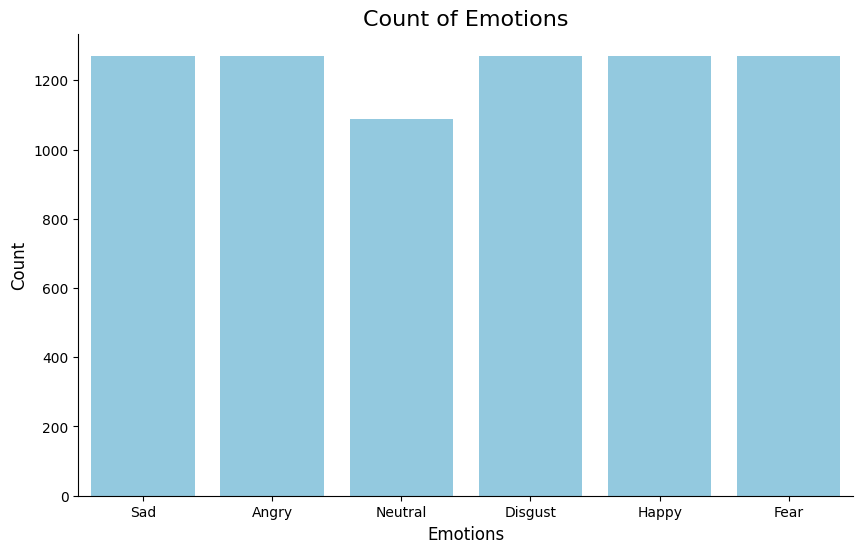

In [12]:
# Plotting the count of emotions
plt.figure(figsize=(10, 6))
sns.countplot(data=df_speech, x='emotion', color='skyblue')
plt.title('Count of Emotions', size=16)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

plt.show()

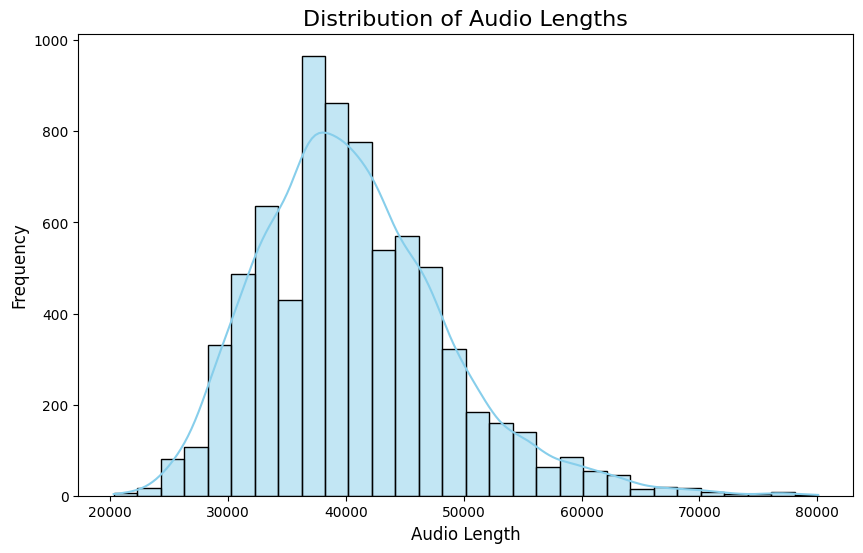

In [13]:
#Distribution of Audio Lengths
plt.figure(figsize=(10, 6))
sns.histplot(df_speech['audio_data'].apply(len), bins=30, kde=True, color='skyblue')
plt.title('Distribution of Audio Lengths', size=16)
plt.xlabel('Audio Length', size=12)
plt.ylabel('Frequency', size=12)
plt.show()

##**Data Argumentation**

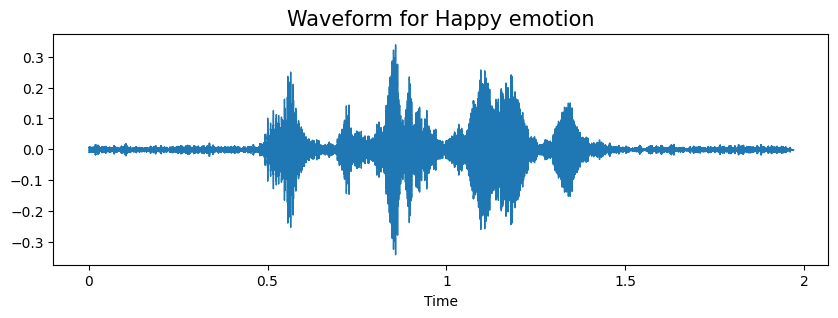

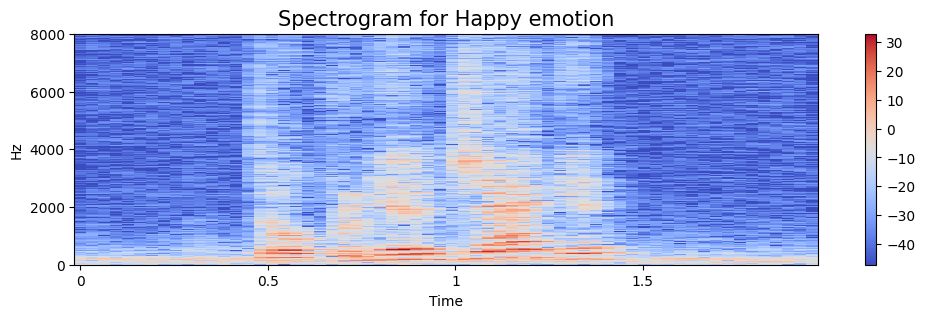

In [15]:
def plot_waveform(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    plt.title('Waveform for {} emotion'.format(emotion), size=15)
    librosa.display.waveshow(y=data, sr=sr)
    plt.show()

def plot_spectrogram(data, sr, emotion):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(emotion), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()

emotion = 'Happy'  # Note the capital 'H'
audio_data = df_speech['audio_data'][df_speech['emotion'] == emotion].iloc[0]
sample_rate = df_speech['sample_rate'][df_speech['emotion'] == emotion].iloc[0]

plot_waveform(audio_data, sample_rate, emotion)
plot_spectrogram(audio_data, sample_rate, emotion)
Audio(audio_data, rate=sample_rate)

##**MFCC Extraction**

In [16]:
labels_mapping = {'disgust': 0, 'happy': 1, 'sad': 2, 'neutral': 3, 'fear': 4, 'angry': 5}
df_speech.replace({'Emotions': labels_mapping}, inplace=True)

In [17]:
# Set the parameters
num_mfcc = 13
n_fft = 2048
hop_length = 512
SAMPLE_RATE = 22050

# Create a data dictionary
data = {"labels": [], "mfcc": []}

# Iterate over the first 100 rows (adjust the range if needed)
for i in range(100):
    label = df_speech.iloc[i, 3]  # Assuming 'Emotions' is in the 4th column
    signal = df_speech.iloc[i, 1]  # Assuming 'audio_data' is in the 2nd column

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=signal, sr=SAMPLE_RATE, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T

    # Append to the data dictionary
    data["labels"].append(label)
    data["mfcc"].append(np.asarray(mfcc))

    # Print progress
    if i % 10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90


##**Padding MFCC to make them of equal length**

In [18]:
# Padding MFCCs to make them of equal length
X_padded = pad_sequences(data["mfcc"], padding='post', dtype='float32', truncating='post')
X = np.asarray(X_padded)

# Convert labels to numpy array
y = np.asarray(data["labels"])

##**Split train and test**

In [19]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

##**LabelEncoder**

In [20]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels in the training set
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform the labels in the validation set
y_validation_encoded = label_encoder.transform(y_validation)

##**Model Architecture**

In [21]:
# Build the LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(6, activation='softmax'))
    return model

In [22]:
# Create the model
input_shape = (None, num_mfcc)
model = build_model(input_shape)

In [23]:
# Compile the model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         72704     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 126662 (494.77 KB)
Trainable params: 126662 (494.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
# Use the encoded labels for training
history = model.fit(X_train, y_train_encoded, validation_data=(X_validation, y_validation_encoded), batch_size=32, epochs=28)

Epoch 1/28
3/3 [==============================] - 1s 236ms/step - loss: 0.0261 - accuracy: 1.0000 - val_loss: 2.7371 - val_accuracy: 0.5556
Epoch 2/28
3/3 [==============================] - 1s 184ms/step - loss: 0.0203 - accuracy: 1.0000 - val_loss: 2.6945 - val_accuracy: 0.5556
Epoch 3/28
3/3 [==============================] - 1s 203ms/step - loss: 0.0396 - accuracy: 0.9861 - val_loss: 2.7062 - val_accuracy: 0.6111
Epoch 4/28
3/3 [==============================] - 1s 194ms/step - loss: 0.0221 - accuracy: 1.0000 - val_loss: 2.6655 - val_accuracy: 0.6111
Epoch 5/28
3/3 [==============================] - 1s 206ms/step - loss: 0.0205 - accuracy: 1.0000 - val_loss: 2.6641 - val_accuracy: 0.6111
Epoch 6/28
3/3 [==============================] - 1s 196ms/step - loss: 0.0277 - accuracy: 1.0000 - val_loss: 2.7686 - val_accuracy: 0.5556
Epoch 7/28
3/3 [==============================] - 1s 196ms/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 2.9268 - val_accuracy: 0.5556
Epoch 8/28
3/3 [====

In [37]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, label_encoder.transform(y_test))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 [==============================] - 0s 109ms/step - loss: 2.5799 - accuracy: 0.6000
Test Accuracy: 60.00%


##**Predict**

In [38]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

1/1 [==============================] - 0s 113ms/step


In [39]:
# Decode the encoded labels back to original labels
y_test_original = label_encoder.inverse_transform(label_encoder.transform(y_test))
y_pred_classes_original = label_encoder.inverse_transform(y_pred_classes)

##**Classification Report**

In [40]:
  # Generate classification report
classification_rep = classification_report(y_test_original, y_pred_classes_original)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

       Angry       0.67      1.00      0.80         2
     Disgust       0.50      1.00      0.67         1
        Fear       0.50      0.50      0.50         2
       Happy       0.00      0.00      0.00         1
     Neutral       0.67      1.00      0.80         2
         Sad       0.00      0.00      0.00         2

    accuracy                           0.60        10
   macro avg       0.39      0.58      0.46        10
weighted avg       0.42      0.60      0.49        10



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
